# Building a Continuous Normalizing Flow (CNF)
Continuing from section 22.2.6 of the book. A continuous normalizing flow is the continuous-time expansion of normalizing flows in the limit as the number of layers of affine transformations approaches infinity. We can model this continuous setting as: 

$$
\frac{d \boldsymbol{x}}{dt} = \boldsymbol{F}( \boldsymbol{x} (t), t),
$$

where $\boldsymbol{F} : \mathbb{R}^D \times [0,T] → \mathbb{R}^D$ is a time dependent vector field that parameterizes the ODE. In this setting, our flow from base $p(u)$ to $p(x)$ is the integration of the differential equation from $t=0$ to $t=1$ of the defined differential equation. Note, that we can define the differential equation on the right-hand side of the equation by any arbitrary neural network that may have $k$ layers, as we'll see in a moment. 

We need to define the flow of a data point, $x$, from a base distribution to the data distribution. The defined differential equation can be thought of as the velocity of particle $x(t)$ at some time point $t$. Thus, numerically integrating by Euler's method or another more advanced technique will result in the path from the base to data distribution. We define this change as:

$$
\frac{d L}{dt} (t) = \text{tr}[ \boldsymbol{J} ( \boldsymbol{F}( \cdot , (t))( x(t))],
$$

where $L(t)$ s the Jacobian determinant of $\boldsymbol{f}$ that we would like to define. So, we need to keep track of both the particle $x$ position at each time point, as well as the Jacobian determinant. It's important to note that the right-hand side is the divergence of $\boldsymbol{f}$. The divergence is usually difficult to calculate but the Hutchinson Trace estimator can be used to approximate the Jacobian trace of $\boldsymbol{F}(\cdot, t)$.

What's interesting to note is that the right-hand side of the equation is a composition of arbitrary neural networks linked together that do not need to satisfy the invertibility constraint of affine normalizing flows due to the Piccard Existence Theorem. Briefly, if the functions are uniformly Lipschitz continuous and continuous in $t$, then the ODE has a unique solution. Many neural networks have this property and allow one to skip the invertibility requirement and tractability of the Jacobian determinant. 

More explicitly, the function $\boldsymbol{F}$ can be composed of $k$ neural networks, $\boldsymbol{f}$. Plugging this into the differential equation, this looks like:

$$
\boldsymbol{x} = \boldsymbol{u} + \int_0^T \sum_{k}^D \frac{\partial f_{\theta, k}}{\partial x_k} (t, x(t, x_i)) dt .
$$

So, for each timestep, all $k$ functional layers, $\boldsymbol{f}_{\theta}$, need to be evaluated. We solve by going backwards from $\boldsymbol{u} → \boldsymbol{x}$, which is simply

$$
\boldsymbol{u} = \boldsymbol{x} + \int_T^0 \sum_{k}^D \frac{\partial f_{\theta, k}}{\partial x_k} (t, x(t, x_i)) dt = \boldsymbol{x} - \int_0^T \sum_{k}^D \frac{\partial f_{\theta, k}}{\partial x_k} (t, x(t, x_i)) dt .
$$

This formulation allows evaluation to proceed by either forward or backward evalution of the data point in time. Note that backpropagation will have to be evaluated in the reverse direction, which will require the ODE solver to be able to go backwards in time, regardless of integration limits chosen here! 

## Implementing the CNF
Theory reviewed, we can implement the CNF. We will work off of (directly copy, mostly) Patrick Kidger's example code for his `diffrax` library for differential equation solvers, found [here](https://docs.kidger.site/diffrax/examples/continuous_normalising_flow/). As of July 2022, this is the most comprehensive Jax library for differential equation solvers. We will also work with the `equinox` neural network library instead of `haiku`, as the `equinox` library allows for more easily reversing neural network modules than `haiku`. Even though `haiku` or `flax` could be used if their layers can be reversed, that requires a little more work than just using `equinox` in this case. 

We also use the `diffrax` library as it enables us to plug into other differential equations that can be used with probabilistic models, such as stochastic differential equations that can be used with diffusion models. 




In [1]:
import math
import os
import matplotlib.pyplot as plt
import pathlib
import time
from typing import List, Tuple

from IPython.display import clear_output
from sklearn import datasets, preprocessing
import jax
import jax.numpy as jnp
import numpy as np
import jax.lax as lax
import jax.nn as jnn
import jax.random as jrandom
import scipy.stats as stats

try:
    from probml_utils import savefig, latexify
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    from probml_utils import savefig, latexify
try:
    import diffrax
except ModuleNotFoundError:
    %pip install -qq diffrax
    import diffrax
try:
    import optax
except ModuleNotFoundError:
    %pip install -qq optax
    import optax

try:
    import equinox as eqx  # https://github.com/patrick-kidger/equinox
except ModuleNotFoundError:
    %pip install -qq equinox
    import equinox as eqx


here = pathlib.Path(os.getcwd())

# Loading up the two moons dataset
n_samples = 10000

scaler = preprocessing.StandardScaler()
X, _ = datasets.make_moons(n_samples=n_samples, noise=0.05)
X = scaler.fit_transform(X)

input_dim = X.shape[1]


class Func(eqx.Module):
    layers: List[eqx.nn.Linear]

    def __init__(self, *, data_size, width_size, depth, key, **kwargs):
        super().__init__(**kwargs)
        keys = jrandom.split(key, depth + 1)
        layers = []
        if depth == 0:
            layers.append(ConcatSquash(in_size=data_size, out_size=data_size, key=keys[0]))
        else:
            layers.append(ConcatSquash(in_size=data_size, out_size=width_size, key=keys[0]))
            for i in range(depth - 1):
                layers.append(ConcatSquash(in_size=width_size, out_size=width_size, key=keys[i + 1]))
            layers.append(ConcatSquash(in_size=width_size, out_size=data_size, key=keys[-1]))
        self.layers = layers

    def __call__(self, t, y, args):
        t = jnp.asarray(t)[None]
        for layer in self.layers[:-1]:
            y = layer(t, y)
            y = jnn.tanh(y)
        y = self.layers[-1](t, y)
        return y


# Credit: this layer, and some of the default hyperparameters below, are taken from the
# FFJORD repo.
class ConcatSquash(eqx.Module):
    lin1: eqx.nn.Linear
    lin2: eqx.nn.Linear
    lin3: eqx.nn.Linear

    def __init__(self, *, in_size, out_size, key, **kwargs):
        super().__init__(**kwargs)
        key1, key2, key3 = jrandom.split(key, 3)
        self.lin1 = eqx.nn.Linear(in_size, out_size, key=key1)
        self.lin2 = eqx.nn.Linear(1, out_size, key=key2)
        self.lin3 = eqx.nn.Linear(1, out_size, use_bias=False, key=key3)

    def __call__(self, t, y):
        return self.lin1(y) * jnn.sigmoid(self.lin2(t)) + self.lin3(t)


def approx_logp_wrapper(t, y, args):
    y, _ = y
    *args, eps, func = args
    fn = lambda y: func(t, y, args)
    f, vjp_fn = jax.vjp(fn, y)
    (eps_dfdy,) = vjp_fn(eps)
    logp = jnp.sum(eps_dfdy * eps)
    return f, logp


def exact_logp_wrapper(t, y, args):
    y, _ = y
    *args, _, func = args
    fn = lambda y: func(t, y, args)
    f, vjp_fn = jax.vjp(fn, y)
    (size,) = y.shape  # this implementation only works for 1D input
    eye = jnp.eye(size)
    (dfdy,) = jax.vmap(vjp_fn)(eye)
    logp = jnp.trace(dfdy)
    return f, logp


def normal_log_likelihood(y):
    return -0.5 * (y.size * math.log(2 * math.pi) + jnp.sum(y**2))


class CNF(eqx.Module):
    funcs: List[Func]
    data_size: int
    exact_logp: bool
    t0: float
    t1: float
    dt0: float

    def __init__(
        self,
        *,
        data_size,
        exact_logp,
        num_blocks,
        width_size,
        depth,
        key,
        **kwargs,
    ):
        super().__init__(**kwargs)
        keys = jrandom.split(key, num_blocks)
        self.funcs = [
            Func(
                data_size=data_size,
                width_size=width_size,
                depth=depth,
                key=k,
            )
            for k in keys
        ]
        self.data_size = data_size
        self.exact_logp = exact_logp
        self.t0 = 0.0
        self.t1 = 0.5
        self.dt0 = 0.05

    # Runs backward-in-time to train the CNF.
    def train(self, y, *, key):
        if self.exact_logp:
            term = diffrax.ODETerm(exact_logp_wrapper)
        else:
            term = diffrax.ODETerm(approx_logp_wrapper)
        solver = diffrax.Tsit5()
        eps = jrandom.normal(key, y.shape)
        delta_log_likelihood = 0.0
        for func in reversed(self.funcs):
            y = (y, delta_log_likelihood)
            sol = diffrax.diffeqsolve(term, solver, self.t1, self.t0, -self.dt0, y, (eps, func))
            (y,), (delta_log_likelihood,) = sol.ys
        return delta_log_likelihood + normal_log_likelihood(y)

    # To make illustrations, we have a variant sample method we can query to see the
    # evolution of the samples during the forward solve.
    def sample_flow(self, *, key):
        t_so_far = self.t0
        t_end = self.t0 + (self.t1 - self.t0) * len(self.funcs)
        save_times = jnp.linspace(self.t0, t_end, 9)
        y = jrandom.normal(key, (self.data_size,))
        out = []
        for i, func in enumerate(self.funcs):
            if i == len(self.funcs) - 1:
                save_ts = save_times[t_so_far <= save_times] - t_so_far
            else:
                save_ts = save_times[(t_so_far <= save_times) & (save_times < t_so_far + self.t1 - self.t0)] - t_so_far
                t_so_far = t_so_far + self.t1 - self.t0
            term = diffrax.ODETerm(func)
            solver = diffrax.Tsit5()
            saveat = diffrax.SaveAt(ts=save_ts)
            sol = diffrax.diffeqsolve(term, solver, self.t0, self.t1, self.dt0, y, saveat=saveat)
            out.append(sol.ys)
            y = sol.ys[-1]
        out = jnp.concatenate(out)
        assert len(out) == 9  # number of points we saved at
        return out


from functools import partial


class DataLoader(eqx.Module):
    arrays: Tuple[jnp.ndarray]
    batch_size: int
    key: jrandom.PRNGKey

    def __post_init__(self):
        dataset_size = self.arrays[0].shape[0]
        assert all(array.shape[0] == dataset_size for array in self.arrays)

    # @partial(jax.jit, static_argnums=1)
    def __call__(self, step):
        # dataset_size = self.arrays[0].shape[0]
        dataset_size = self.arrays.shape[0]
        num_batches = dataset_size // self.batch_size
        epoch = step // num_batches
        key = jrandom.fold_in(self.key, epoch)
        perm = jrandom.permutation(key, jnp.arange(dataset_size))
        start = step * self.batch_size
        slice_size = self.batch_size
        batch_indices = lax.dynamic_slice_in_dim(perm, start, slice_size)
        # return tuple(array[batch_indices] for array in self.arrays)
        return self.arrays[batch_indices]


def main(
    in_path,
    out_path=None,
    batch_size=500,
    virtual_batches=2,
    lr=1e-3,
    weight_decay=1e-5,
    steps=4000,  # Change this
    exact_logp=True,
    num_blocks=2,
    width_size=64,
    depth=3,
    print_every=10,
    seed=5678,
):
    if out_path is None:
        out_path = here / pathlib.Path(in_path).name
    else:
        out_path = pathlib.Path(out_path)

    key = jrandom.PRNGKey(seed)
    model_key, loader_key, loss_key, sample_key = jrandom.split(key, 4)

    dataset_size, data_size = X.shape
    dataloader = DataLoader(jnp.asarray(X), batch_size, key=loader_key)

    model = CNF(
        data_size=data_size,
        exact_logp=exact_logp,
        num_blocks=num_blocks,
        width_size=width_size,
        depth=depth,
        key=model_key,
    )

    optim = optax.adamw(lr, weight_decay=weight_decay)
    opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

    @eqx.filter_value_and_grad
    def loss(model, data, loss_key):
        batch_size, _ = data.shape
        noise_key, train_key = jrandom.split(loss_key, 2)
        train_key = jrandom.split(key, batch_size)
        log_likelihood = jax.vmap(model.train)(data, key=train_key)
        return -jnp.mean(log_likelihood)  # minimise negative log-likelihood

    @eqx.filter_jit
    def make_step(model, opt_state, step, loss_key):
        # We only need gradients with respect to floating point JAX arrays, not any
        # other part of our model. (e.g. the `exact_logp` flag. What would it even mean
        # to differentiate that? Note that `eqx.filter_value_and_grad` does the same
        # filtering by `eqx.is_inexact_array` by default.)
        value = 0
        grads = jax.tree_map(
            lambda leaf: jnp.zeros_like(leaf) if eqx.is_inexact_array(leaf) else None,
            model,
        )

        # Get more accurate gradients by accumulating gradients over multiple batches.
        # (Or equivalently, get lower memory requirements by splitting up a batch over
        # multiple steps.)
        def make_virtual_step(_, state):
            value, grads, step, loss_key = state
            data = dataloader(step)
            value_, grads_ = loss(model, data, loss_key)
            value = value + value_
            grads = jax.tree_map(lambda a, b: a + b, grads, grads_)
            step = step + 1
            loss_key = jrandom.split(loss_key, 1)[0]
            return value, grads, step, loss_key

        value, grads, step, loss_key = lax.fori_loop(
            0, virtual_batches, make_virtual_step, (value, grads, step, loss_key)
        )
        value = value / virtual_batches
        grads = jax.tree_map(lambda a: a / virtual_batches, grads)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return value, model, opt_state, step, loss_key

    step = 0
    while step < steps:
        start = time.time()
        value, model, opt_state, step, loss_key = make_step(model, opt_state, step, loss_key)
        end = time.time()
        if (step % print_every) == 0 or step == steps - 1:
            print(f"Step: {step}, Loss: {value}, Computation time: {end - start}")

    num_samples = 5000
    sample_key = jrandom.split(sample_key, num_samples)
    sample_flows = jax.vmap(model.sample_flow, out_axes=-1)(key=sample_key)
    return sample_flows


sample_flows = main(in_path=".")

flow_list = [flow for flow in sample_flows]

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 88 kB 4.1 MB/s 
     |████████████████████████████████| 125 kB 32.2 MB/s 
     |████████████████████████████████| 272 kB 57.5 MB/s 
     |████████████████████████████████| 72 kB 806 kB/s 
     |████████████████████████████████| 1.1 MB 65.2 MB/s 
     |████████████████████████████████| 108 kB 4.6 MB/s 
     |████████████████████████████████| 64 kB 4.0 MB/s 
     |████████████████████████████████| 145 kB 4.9 MB/s 
Step: 10, Loss: 2.836486577987671, Computation time: 0.6750609874725342
Step: 20, Loss: 2.8074450492858887, Computation time: 0.6732790470123291
Step: 30, Loss: 2.768716335296631, Computation time: 0.68011474609375
Step: 40, Loss: 2.750795602798462, Computation time: 0.6778175830841064
Step: 50, Loss: 2.7379398345947266, Computation time: 0.6726047992706299
Step: 60, Loss: 2.7201666831970215, Computation time: 0.67

## Comparing the NSF to the CNF
We've trained both models, now we can compare how they sample from a base Gaussian distribution to the data distribution. To do this, we sample once from each layer of the `NSF` to get a cumulative change due to the flow, with the last layer converting to the data distribution. 

Sampling the `CNF` is a little different. Since the `CNF` is modeled by a vector field changing from an initial timepoint to a final timepoint, we sample by evaluating the vector field at intermediate timesteps between the beginning and end time points. 

Comparing the two plots, you shouldd be able to see the difference between how each normalizing flow models the diffeomorphism from base to data distribution. The `NSF` makes more "jagged" steps, reminiscent of a taffy machine, while the `CNF` makes more smooth steps given the Lipschitz constraints of the neural networks that model its vector field. 

Note, however, that transitions of the `CNF` are limited by the expressiveness of the neural network used to describe the differential equation's vector field. This [paper](https://arxiv.org/abs/1904.01681) by Dupont et al. (2019) demonstrates how to overcome a shortcoming of Neural ODEs. 

Text(99.125, 0.5, 'CNF')

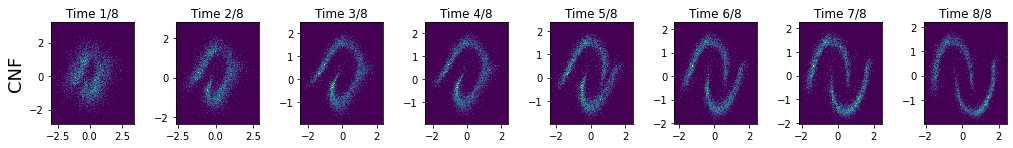

In [6]:
fig, axes = plt.subplots(1, 8, figsize=(14, 2))
fig.tight_layout()

# CNF plots
for j in range(1, len(flow_list)):
    axes[j - 1].hist2d(flow_list[j][0, :], flow_list[j][1, :], bins=100)[-1]
    axes[j - 1].set_title(f"Time {j}/8")

axes[0].set_ylabel("CNF", fontsize=18)

In [7]:
fig.savefig("two-moons-cnf.pdf", bbox_inches="tight")
fig.savefig("two-moons-cnf.png", bbox_inches="tight")